## Processing the ICF dataset to update the true and false analogue pairs with similarity metrics on the basis of structure, metabolism, alerts and physicochemical similarity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
from pathlib import Path

In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

In [13]:
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform

In [15]:
opera_df = pd.read_csv(interim_dir/'rax-sdf_OPERA2.9Pred.csv')


In [16]:
opera_df = opera_df[['MoleculeID','MolWeight','nbHBdAcc',
 'ndHBdDon','LogP_pred',]]

In [17]:
opera_df = opera_df.set_index('MoleculeID')

In [23]:
opera_df

,MolWeight,nbHBdAcc,ndHBdDon,LogP_pred
MoleculeID,,,,
DTXSID4020298,112.007978,0,0,2.86
DTXSID1020431,145.969005,0,0,3.44
DTXSID6020430,145.969005,0,0,3.43
DTXSID6022056,145.969005,0,0,3.53
DTXSID0021965,179.930033,0,0,3.99
...,...,...,...,...
DTXSID8024280,341.069782,5,0,3.72
DTXSID4034869,343.031288,4,2,4.05
DTXSID9032113,307.145140,4,1,3.70


In [18]:
physchem = opera_df.copy()

In [19]:
scaler= MinMaxScaler()

In [24]:
physchem2 = pd.DataFrame(scaler.fit_transform(physchem), columns = ['MolWeight', 'nbHBdAcc', 'ndHBdDon', 'LogP_pred'],index = physchem.index) 

In [25]:
def distance_matrix_euclidean(df):
    '''
    Function to create a pairwise square distance matrix using the Jaccard index
    '''
    D_phys = pd.DataFrame(squareform(pdist(df, 'euclidean')), columns = df.index, index = df.index)

    return D_phys


In [26]:
physchem2

,MolWeight,nbHBdAcc,ndHBdDon,LogP_pred
MoleculeID,,,,
DTXSID4020298,0.103133,0.000000,0.000,0.477210
DTXSID1020431,0.146392,0.000000,0.000,0.517265
DTXSID6020430,0.146392,0.000000,0.000,0.516575
DTXSID6022056,0.146392,0.000000,0.000,0.523481
DTXSID0021965,0.189651,0.000000,0.000,0.555249
...,...,...,...,...
DTXSID8024280,0.394909,0.384615,0.000,0.536602
DTXSID4034869,0.397407,0.307692,0.250,0.559392
DTXSID9032113,0.351696,0.307692,0.125,0.535221


In [42]:
physchem2 = physchem2[~physchem2.index.duplicated(keep='first')]

In [43]:
S_physchem = 1- (distance_matrix_euclidean(physchem2))
S_physchem

,DTXSID4020298,DTXSID1020431,DTXSID6020430,DTXSID6022056,DTXSID0021965,DTXSID8026193,DTXSID8026195,DTXSID1026089,DTXSID6026088,DTXSID7024320,...,DTXSID8032548,DTXSID4034653,DTXSID8024315,DTXSID2024242,DTXSID8042260,DTXSID8024280,DTXSID4034869,DTXSID9032113,DTXSID0032493,DTXSID3023897
DTXSID4020298,1.000000,0.941044,0.941511,0.936657,0.883486,0.879235,0.873818,0.822663,0.824069,0.822192,...,0.579504,0.574496,0.619178,0.594935,0.677237,0.513595,0.499474,0.581134,0.594163,0.615398
DTXSID1020431,0.941044,1.000000,0.999309,0.993785,0.942432,0.938154,0.932516,0.881618,0.883023,0.881146,...,0.608148,0.604251,0.641321,0.618277,0.710004,0.541673,0.528876,0.609140,0.615579,0.636770
DTXSID6020430,0.941511,0.999309,1.000000,0.993094,0.941974,0.937659,0.931984,0.881146,0.882557,0.880671,...,0.608173,0.604195,0.641387,0.618307,0.709959,0.541644,0.528814,0.609108,0.615645,0.636857
DTXSID6022056,0.936657,0.993785,0.993094,1.000000,0.946329,0.942432,0.937160,0.885770,0.887112,0.885318,...,0.607869,0.604702,0.640670,0.617957,0.710337,0.541893,0.529391,0.609376,0.614926,0.635926
DTXSID0021965,0.883486,0.942432,0.941974,0.946329,1.000000,0.993785,0.986188,0.939134,0.940573,0.938646,...,0.629853,0.627037,0.655148,0.633848,0.733754,0.563643,0.552390,0.629920,0.629203,0.649927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID8024280,0.513595,0.541673,0.541644,0.541893,0.563643,0.563333,0.562835,0.578158,0.578455,0.578057,...,0.915726,0.848447,0.884376,0.837025,0.829330,1.000000,0.737430,0.846992,0.832141,0.881864
DTXSID4034869,0.499474,0.528876,0.528814,0.529391,0.552390,0.552405,0.552305,0.569037,0.569218,0.568974,...,0.743515,0.868896,0.729316,0.847976,0.726498,0.737430,1.000000,0.864727,0.839816,0.727309
DTXSID9032113,0.581134,0.609140,0.609108,0.609376,0.629920,0.629532,0.628916,0.641728,0.642085,0.641606,...,0.865686,0.984257,0.862278,0.961127,0.850055,0.846992,0.864727,1.000000,0.942664,0.858330
DTXSID0032493,0.594163,0.615579,0.615645,0.614926,0.629203,0.627891,0.626154,0.632647,0.633307,0.632424,...,0.862622,0.927246,0.874652,0.979129,0.842181,0.832141,0.839816,0.942664,1.000000,0.874652


In [44]:
S_physchem.index.name = None

In [45]:
S_physchem.columns.name = None

In [46]:
S_physchem 

,DTXSID4020298,DTXSID1020431,DTXSID6020430,DTXSID6022056,DTXSID0021965,DTXSID8026193,DTXSID8026195,DTXSID1026089,DTXSID6026088,DTXSID7024320,...,DTXSID8032548,DTXSID4034653,DTXSID8024315,DTXSID2024242,DTXSID8042260,DTXSID8024280,DTXSID4034869,DTXSID9032113,DTXSID0032493,DTXSID3023897
DTXSID4020298,1.000000,0.941044,0.941511,0.936657,0.883486,0.879235,0.873818,0.822663,0.824069,0.822192,...,0.579504,0.574496,0.619178,0.594935,0.677237,0.513595,0.499474,0.581134,0.594163,0.615398
DTXSID1020431,0.941044,1.000000,0.999309,0.993785,0.942432,0.938154,0.932516,0.881618,0.883023,0.881146,...,0.608148,0.604251,0.641321,0.618277,0.710004,0.541673,0.528876,0.609140,0.615579,0.636770
DTXSID6020430,0.941511,0.999309,1.000000,0.993094,0.941974,0.937659,0.931984,0.881146,0.882557,0.880671,...,0.608173,0.604195,0.641387,0.618307,0.709959,0.541644,0.528814,0.609108,0.615645,0.636857
DTXSID6022056,0.936657,0.993785,0.993094,1.000000,0.946329,0.942432,0.937160,0.885770,0.887112,0.885318,...,0.607869,0.604702,0.640670,0.617957,0.710337,0.541893,0.529391,0.609376,0.614926,0.635926
DTXSID0021965,0.883486,0.942432,0.941974,0.946329,1.000000,0.993785,0.986188,0.939134,0.940573,0.938646,...,0.629853,0.627037,0.655148,0.633848,0.733754,0.563643,0.552390,0.629920,0.629203,0.649927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID8024280,0.513595,0.541673,0.541644,0.541893,0.563643,0.563333,0.562835,0.578158,0.578455,0.578057,...,0.915726,0.848447,0.884376,0.837025,0.829330,1.000000,0.737430,0.846992,0.832141,0.881864
DTXSID4034869,0.499474,0.528876,0.528814,0.529391,0.552390,0.552405,0.552305,0.569037,0.569218,0.568974,...,0.743515,0.868896,0.729316,0.847976,0.726498,0.737430,1.000000,0.864727,0.839816,0.727309
DTXSID9032113,0.581134,0.609140,0.609108,0.609376,0.629920,0.629532,0.628916,0.641728,0.642085,0.641606,...,0.865686,0.984257,0.862278,0.961127,0.850055,0.846992,0.864727,1.000000,0.942664,0.858330
DTXSID0032493,0.594163,0.615579,0.615645,0.614926,0.629203,0.627891,0.626154,0.632647,0.633307,0.632424,...,0.862622,0.927246,0.874652,0.979129,0.842181,0.832141,0.839816,0.942664,1.000000,0.874652


In [54]:
S_physchem.to_csv(processed_dir/'S_physchem.csv')

In [47]:
df1 = pd.read_csv(interim_dir/'icf_processed_170125.csv', index_col = [0])

In [48]:
mydict = {}
for i, group in df1.groupby('Index'):
    subset = list(group['dtxsid'])
    mydict[i] = subset

In [49]:
physdict = {}
for k,v in mydict.items():
    common_indices = np.intersect1d(v, S_physchem.index)
    # Filter S_react using common indices
    a = S_physchem.loc[common_indices, common_indices]
    mk = np.triu(np.ones_like(a), k=1)
    b = a.where(mk == 1, np.nan).unstack().reset_index().dropna()
    b2 = b[b['level_0'] != b['level_1']]
    b3 = b2[0].to_numpy()
    physdict[k] = b3

In [51]:
new_df = pd.DataFrame({k:v for k,v in physdict.items() if len(v) >1}.items())
new_df['meds'] = [np.median(e) for e in new_df[1]]
new_df = new_df.sort_values(by = 'meds', ascending = False)


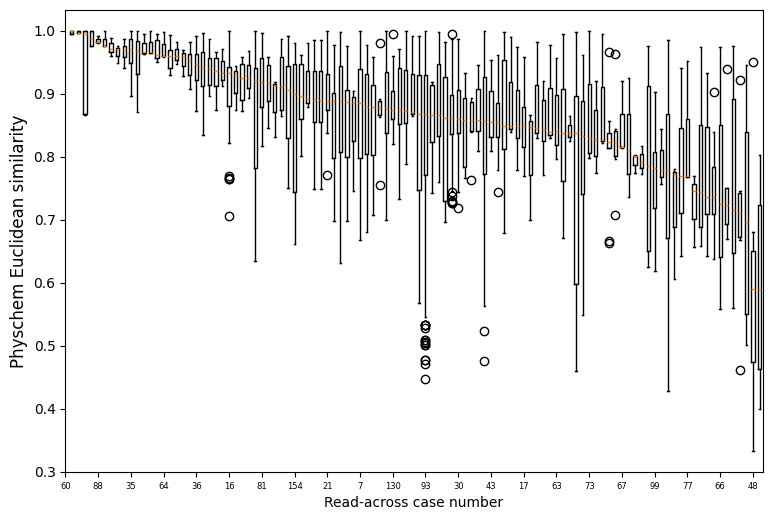

In [52]:
labels, data = list(zip((new_df[0].values, new_df[1].values)))
fig, ax = plt.subplots(figsize = (9,6))
labels, data = list(zip((new_df[0].values, new_df[1].values)))
ax.boxplot(data[0], vert=True)  # Set vert=True to flip the axis

n = 5  # Change this to set the interval of tick labels
selected_indices = range(0, len(labels[0]), n)
selected_labels = [labels[0][i] for i in selected_indices]

# Set the selected tick positions and labels
plt.xticks(selected_indices, selected_labels, fontsize=6)
plt.xlabel('Read-across case number')
plt.ylabel('Physchem Euclidean similarity', fontsize = 12)
fig.savefig(figures_dir/'Physchem_similarity.png', dpi = 300)

In [56]:
#mydict

In [57]:
all_ids = list(set(df1['dtxsid']))

In [59]:
len(all_ids)

695

In [60]:
rax_df = pd.DataFrame(index = all_ids, columns = all_ids)

In [61]:
new_df2 = rax_df.copy()

In [62]:
cases = list(mydict.values())

In [63]:
def update_df(df):
    df1 = df.copy()
    for i in df1.index:
        for c in df1.columns:
            if i == c:
                df1.loc[i,c] =0
            elif any((i in sublist) and (c in sublist) for sublist in cases):
                df1.loc[i, c] =0
            else:
                df1.loc[i, c] = 1
    return df1

In [64]:
updated = update_df(new_df2)

In [65]:
def isSymmetric(mat, N):
    transmat = np.array(mat).transpose()
    if np.array_equal(mat, transmat):
        return True
    return False

In [66]:
updated.shape

(695, 695)

In [67]:
isSymmetric(updated.values, 695)

True

In [68]:
def remove_upper_triangle(df):
    # Get the upper triangle mask
    mask = pd.DataFrame(np.triu(np.ones(df.shape), k=0), columns=df.columns, index=df.index)

    # Set upper triangle values to NaN
    df = df.where(mask == 0)

    return df

In [69]:
new_df3 = remove_upper_triangle(updated)

In [70]:
new_df3 =new_df3.unstack().reset_index().dropna()

In [71]:
new_df3

,level_0,level_1,0
1,DTXSID5023378,DTXSID0044496,1
2,DTXSID5023378,DTXSID4029301,1
3,DTXSID5023378,DTXSID8026488,1
4,DTXSID5023378,DTXSID0029719,1
5,DTXSID5023378,DTXSID6047105,1
...,...,...,...
480938,DTXSID00391682,DTXSID6025804,1
480939,DTXSID00391682,DTXSID7025631,1
481633,DTXSID3020205,DTXSID6025804,1
481634,DTXSID3020205,DTXSID7025631,1


In [72]:
new_df3.columns = ['Target', 'Analogue', 'Label']

In [73]:
new_df3['Label'].value_counts()

Label
1    237754
0      3411
Name: count, dtype: int64

In [77]:
my_smi = {k: v for k,v  in zip(df1['dtxsid'], df1['QSAR Ready SMILES'])}

In [79]:
new_df3['analogue_smi'] = new_df3['Analogue'].apply(lambda x: my_smi[x])
new_df3['target_smi'] = new_df3['Target'].apply(lambda x: my_smi[x])


In [83]:
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit import Chem

In [84]:
fpgen = AllChem.GetMorganGenerator(radius=3, fpSize=1024)

In [88]:
new_df3 = new_df3.dropna()

In [89]:
new_df3['analogue_mol'] = [Chem.MolFromSmiles(e) for e in new_df3['analogue_smi']]

new_df3['target_mol'] = [Chem.MolFromSmiles(e) for e in new_df3['target_smi']]


/tmp/ipykernel_2161920/1448004075.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df3['analogue_mol'] = [Chem.MolFromSmiles(e) for e in new_df3['analogue_smi']]
/tmp/ipykernel_2161920/1448004075.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df3['target_mol'] = [Chem.MolFromSmiles(e) for e in new_df3['target_smi']]


In [90]:
new_df3['fps_target'] = new_df3['target_mol'].apply(lambda x: fpgen.GetFingerprint(x))

/tmp/ipykernel_2161920/2316393511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df3['fps_target'] = new_df3['target_mol'].apply(lambda x: fpgen.GetFingerprint(x))


In [91]:
new_df3['fps_analogue'] = new_df3['analogue_mol'].apply(lambda x: fpgen.GetFingerprint(x))

/tmp/ipykernel_2161920/2208430137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df3['fps_analogue'] = new_df3['analogue_mol'].apply(lambda x: fpgen.GetFingerprint(x))


In [92]:
mylst = []
for i, row in new_df3.iterrows():
    mylst.append(DataStructs.TanimotoSimilarity(row['fps_target'], row['fps_analogue']))


In [93]:
new_df3['Tanimoto'] = mylst

/tmp/ipykernel_2161920/3872381676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df3['Tanimoto'] = mylst


In [95]:
new_df3.to_csv(interim_dir/'rax_pairs_200125.csv')

In [97]:
icf_df = new_df3[['Target', 'Analogue', 'Label', 'analogue_smi', 'target_smi','Tanimoto']]

In [99]:
icf_df.head()

,Target,Analogue,Label,analogue_smi,target_smi,Tanimoto
1,DTXSID5023378,DTXSID0044496,1,CCCCCC1CCCC(=O)O1,NCC(O)C1=CC=C(O)C(O)=C1,0.031746
2,DTXSID5023378,DTXSID4029301,1,Cl[SiH](Cl)Cl,NCC(O)C1=CC=C(O)C(O)=C1,0.000000
3,DTXSID5023378,DTXSID8026488,1,CC1(C)C2CCC(C2)C1=C,NCC(O)C1=CC=C(O)C(O)=C1,0.019231
4,DTXSID5023378,DTXSID0029719,1,CCCCC(CC)COC(=O)CS[Sn](CCCC)(CCCC)SCC(=O)OCC(C...,NCC(O)C1=CC=C(O)C(O)=C1,0.057971
5,DTXSID5023378,DTXSID6047105,1,COC1=CC(C)=CC=C1O,NCC(O)C1=CC=C(O)C(O)=C1,0.170213


In [100]:
wl = pd.read_csv(processed_dir/'WL_times_ivt.csv', index_col = [0])

In [101]:
wl.shape

(620, 620)

In [106]:
def analogue_pair(df, S, label=None):
    mylst = []
    for i, row in df.iterrows():
        a, b = row['Target'], row['Analogue']
        # Check if both 'a' and 'b' are valid indices in the similarity DataFrame
        if a in S.index and b in S.columns:
            c = S.loc[a, b]
            mylst.append([a, b, c])
        else:
            # Log a message or simply skip the pair if indices are not found
            print(f"Warning: One or both indices ({a}, {b}) are not in S")
    
    # Create the resulting DataFrame
    result_df = pd.DataFrame(mylst, columns=['target', 'analogue', label])
    return result_df
    
        

In [107]:
WL_set = analogue_pair(df = icf_df, S = wl, label = 'WL')

In [110]:
S_react = pd.read_csv(external_dir/'OECD_alerts_sim.csv', index_col = [0])

In [112]:
S_react.head()

,DTXSID001304451,DTXSID0020151,DTXSID0020232,DTXSID0020440,DTXSID0020494,DTXSID0020498,DTXSID0020523,DTXSID0020529,DTXSID0020575,DTXSID0021206,...,No_Stearate_sorbitol,Nocas_2747537,Pubchem_102283661,Pubchem_102283662,Pubchem_102283665,Pubchem_102283668,Pubchem_138190,Pubchem_162521585,Pubchem_54176852,Pubchem_562248
DTXSID001304451,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
DTXSID0020151,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.5,0.5,0.5,0.5,0.0,0.0,0.5,1.0
DTXSID0020232,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
DTXSID0020440,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
DTXSID0020494,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
oecd_aps = analogue_pair(df = icf_df, S = S_react, label = 'S_react')

In [114]:
oecd_aps.head()

,target,analogue,S_react
0,DTXSID5023378,DTXSID0044496,0.0
1,DTXSID5023378,DTXSID4029301,0.0
2,DTXSID5023378,DTXSID8026488,0.0
3,DTXSID5023378,DTXSID0029719,0.0
4,DTXSID5023378,DTXSID6047105,0.5


In [115]:
S_physchem
phys_aps = analogue_pair(df = icf_df, S = S_physchem, label = 'S_physchem')

In [117]:
temp = pd.merge(icf_df, oecd_aps, left_on = ['Target', 'Analogue'], right_on = ['target', 'analogue'], how = 'left')

In [118]:
temp.drop(['target','analogue'], axis =1, inplace = True)

In [119]:
temp

,Target,Analogue,Label,analogue_smi,target_smi,Tanimoto,S_react
0,DTXSID5023378,DTXSID0044496,1,CCCCCC1CCCC(=O)O1,NCC(O)C1=CC=C(O)C(O)=C1,0.031746,0.0
1,DTXSID5023378,DTXSID4029301,1,Cl[SiH](Cl)Cl,NCC(O)C1=CC=C(O)C(O)=C1,0.000000,0.0
2,DTXSID5023378,DTXSID8026488,1,CC1(C)C2CCC(C2)C1=C,NCC(O)C1=CC=C(O)C(O)=C1,0.019231,0.0
3,DTXSID5023378,DTXSID0029719,1,CCCCC(CC)COC(=O)CS[Sn](CCCC)(CCCC)SCC(=O)OCC(C...,NCC(O)C1=CC=C(O)C(O)=C1,0.057971,0.0
4,DTXSID5023378,DTXSID6047105,1,COC1=CC(C)=CC=C1O,NCC(O)C1=CC=C(O)C(O)=C1,0.170213,0.5
...,...,...,...,...,...,...,...
213526,DTXSID00391682,DTXSID6025804,1,CCCCCCC=C,CCC(C)(C)C1=CC(C)=C(O)C(C)=C1,0.095238,0.0
213527,DTXSID00391682,DTXSID7025631,1,CC1=CC=CC(=C1N)[N+]([O-])=O,CCC(C)(C)C1=CC(C)=C(O)C(C)=C1,0.102041,0.0
213528,DTXSID3020205,DTXSID6025804,1,CCCCCCC=C,CCCCOC(=O)C1=C(C=CC=C1)C(=O)OCC1=CC=CC=C1,0.101695,0.0
213529,DTXSID3020205,DTXSID7025631,1,CC1=CC=CC(=C1N)[N+]([O-])=O,CCCCOC(=O)C1=C(C=CC=C1)C(=O)OCC1=CC=CC=C1,0.106061,0.0


In [120]:
temp2 = pd.merge(temp, phys_aps, left_on = ['Target', 'Analogue'], right_on = ['target', 'analogue'], how = 'left')

In [121]:
temp2.drop(['target','analogue'], axis =1, inplace = True)

In [122]:
temp2 = pd.merge(temp2, WL_set, left_on = ['Target', 'Analogue'], right_on = ['target', 'analogue'], how = 'left')



In [123]:
temp2.drop(['target','analogue'], axis =1, inplace = True)

In [129]:
temp2 = (temp2
 .rename(columns = {'Tanimoto': 'S_struct', 'WL': 'S_metab'})
)

In [130]:
temp2.to_csv(interim_dir/'sims_200125.csv')

<Axes: >

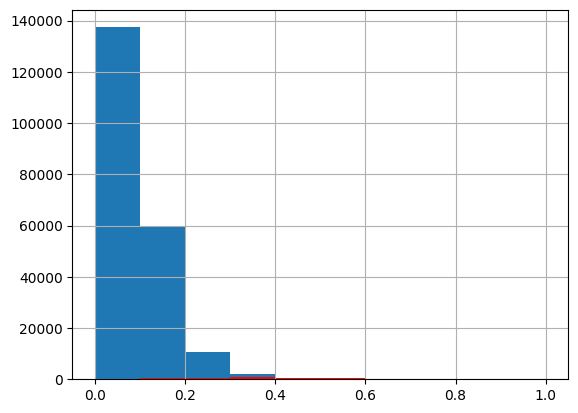

In [134]:
temp2[temp2['Label'] == 1]['S_struct'].hist()
temp2[temp2['Label'] == 0]['S_struct'].hist(color = 'r')

In [133]:
temp2.dropna().to_csv(interim_dir/'sims_notnull_200125.csv')